# Octree Querying Practice

In [267]:
import numpy as np
import matplotlib.pyplot as plt

Let's work with a basic `Octree` structure in python and see how querying works within it. To keep things simple, we will start off in 2 dimensions and work our way up from there. Technically speaking, this data structure will now be called a `quadtree`.

First, let's start off by creating a 2D space that will comprise our entire `scene`.

In [268]:
# Create the base 2D space 80 x 80 dimensions
grid = np.zeros([80,80])
grid.shape

(80, 80)

Now, let's add some random object to the scene. We add 200 objects scattered randomly in the space. This iwll conrrespond to the centroid of our individual objects.

In [269]:
# Create 200 random objects and add them to the grid.
objects_dict = {}

for i in range (200):
    X = np.random.randint(0,79)
    Y = np.random.randint(0,79)
    
    objects_dict[str(i)]=(X,Y)

    # Need to swap the order of X and Y, since matrix notation is [ row, column ]
    grid[Y][X] = i

np.count_nonzero(grid)

np.int64(199)

Now we create our `quadtree` implementation. The code below uses a recursive function to create the tree by repeatedly sibdividing the spaec into smaller and smaller squares. The structure of our quadtree will be a nested dictionary. Each level of the dictionary contains a nested dictionary, as well as a tuple which contains the coordinates of the box's `bounds`.

In [270]:
def make_quadtree(x_l, x_r, y_t, y_b, depth=3):
    """
    Docstring for make_quadtree
    
    :param depth: Description
    :input_grid: Description
    """
    quad_tree = {}
    
    if depth == 0:
        return quad_tree
    
    quad_tree['bounds'] = (x_l, x_r, y_t, y_b)
    quad_tree[0] = make_quadtree(x_l, x_r - (x_r - x_l)/2, y_t - (y_t - y_b)/2, y_b, depth-1)
    quad_tree[1] = make_quadtree(x_r - (x_r - x_l)/2, x_r, y_t - (y_t - y_b)/2, y_b, depth-1)
    quad_tree[2] = make_quadtree(x_l, x_r - (x_r - x_l)/2, y_t, y_t - (y_t - y_b)/2, depth-1)
    quad_tree[3] = make_quadtree(x_r - (x_r - x_l)/2, x_r, y_t, y_t - (y_t - y_b)/2, depth-1)

    return quad_tree


Let's run some tests to see that our `quadtree` is working as expected.

In [271]:
qt = make_quadtree(0,80,80,0, depth=5)
print(qt[2][0][0]['bounds'])

(0, 10.0, 50.0, 40.0)


We get the answer as expected. I'd like to see what this quadtree looks like in 2D space. Below we create a simple plotting function `draw_rect` that will draw rectangles on a plot, given its bounding coordinates.

In [272]:
def draw_rect(coords, ax, color, **kwargs):
    """
    Docstring for draw_rect
    
    :param coords: Description
    :param plt: Description
    """
    x_l, x_r, y_t, y_b = coords
    X = np.array([x_l, x_l, x_r, x_r, x_l])
    Y = np.array([y_t, y_b, y_b, y_t, y_t])
    
    ax.plot(X,Y, color=color, **kwargs)

Now, lets test this out on our `quadtree`.

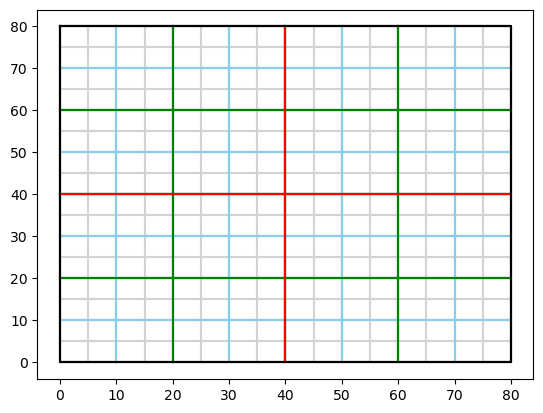

In [273]:
fig, ax = plt.subplots()

for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                draw_rect(qt[i][j][k][l]['bounds'], ax, 'lightgrey')

for i in range(4):
    for j in range(4):
        for k in range(4):
            draw_rect(qt[i][j][k]['bounds'], ax, 'skyblue')

for i in range(4):
    for j in range(4):
        draw_rect(qt[i][j]['bounds'], ax, 'green')

for i in range(4):
    draw_rect(qt[i]['bounds'], ax, 'red')

draw_rect(qt['bounds'], ax, 'black')

plt.show()

The results are spectacular. We see our root node of the quadtree (drawn in black), and the repeated subdivisions of space. For example, level 2 of the quadtree (in red), divides the space into 4 equal squares. Level 3 (drawn in green) of the quadtree, divides each individual square from the previous level into an additional 4 squares. Level 4 corresponds to skyblue, and Level 5 is in light grey. Each one of these squares acts as a spatial query which we can use to test for certain conditions.

The next step is to define a function that tests to see if our input position (camera position) and its search radius intersects with a given level of a quadtree. Since our final implementation will be nested, we only need to test for intersection between one rectangle (corresponding to the quadtree box), and a cicle (corresponding to the camera search radius). Here is what the code looks like.

In [274]:
def is_intersecting(pos: tuple, coords: tuple, threshold=5):
    """
    Docstring for is_intersecting
    
    :param pos: Description
    :type pos: tuple
    :param input_tree: Description
    :param threshold: Description
    """
    camera_x, camera_y = pos
    x_l, x_r, y_t, y_b = coords

    # Find where the camera is with reference to the box

    # Base case for if camera is within the box
    if (x_l < camera_x) & (camera_x < x_r) & (y_b < camera_y) & (camera_y < y_t):
        return True

    # find the X and Y coordinate of the nearest side of the box
    closest_x = max(x_l, min(camera_x, x_r))
    closest_y = max(y_b, min(camera_y, y_t))

    # find the length of the line from camera center to box edge
    curr_dist = (closest_x - camera_x)**2 + (closest_y - camera_y)**2
    
    if curr_dist < threshold**2:
        return True
    else:
        return False

This code was developed in part, with assistance from Google Gemini. This is how it works.

1) Base case: If the X_coordinate and Y_coordinate of our `camera_pos` is within the range of our rectangle, we can say for certain that the camera is within the box and se we return `True`.
2) If the base case is False, that means our camera is somewhere outside our quadtree box. In this case, we need to test if the radius is shorter than the line between the camera and perimeter of the box. How do we get this line? The line connecting the camera to the perimieter of the box, will either be perpedicular to the box (in the case that the circle is directly beside, below or above the box), or diagonal (in the case that the circle is off-axis from the box). The diagram below shows this better.

![Quad Tree Intersection Test-base case](../img/octree-intersection-basecase.png)

![Quad Tree Intersection Test-case1](../img/octree-intersection-case1.png)

![Quad Tree Intersection Test-case2](../img/octree-intersection-case2.png)

![Quad Tree Intersection Test-case3](../img/octree-intersection-case3.png)

For plotting purposes, lets create a color map that will correspond to the different levels in our quadtree.

In [275]:
# Create a color map for the different levels of the quadtree
color_map = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'skyblue',
    4: 'lightgrey'
}

Now we define the `draw_quadtree` function. This function will take in the current camera position, and navigate down the levels of the quadtree, only if the current level intersects with the camera's radius (denoted by `threshold`).

In [276]:
def draw_quadtree(pos:tuple, q_tree, threshold=5, level=0):
    """
    Docstring for draw_quadtree
    
    :param pos: Description
    :type pos: tuple
    :param q_tree: Description
    :param threshold: Description
    """
     
    if is_intersecting(pos, q_tree['bounds'], threshold):
        draw_rect(q_tree['bounds'], plt, color_map[level], zorder=5-level)
        try:
            draw_quadtree(pos, q_tree[0], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, q_tree[1], threshold, level = level+1)
        except:
            return

        try:
            draw_quadtree(pos, q_tree[2], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, q_tree[3], threshold, level = level+1)
        except:
            return

    return

Let's see what we get when we pass in different values for `camera_pos` and radius `r`.

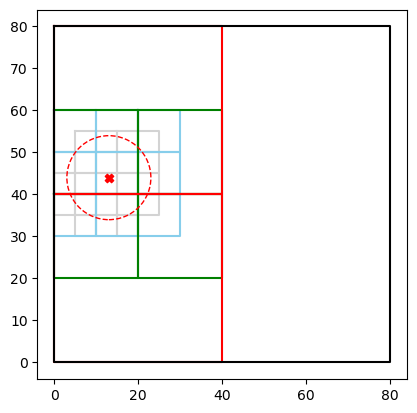

In [277]:
camera_pos = (13,44)
r=10

fig, ax = plt.subplots()

draw_quadtree(camera_pos, qt, threshold=r)

camera_x, camera_y = camera_pos
ax.scatter(camera_x,camera_y, marker='X', color='red', zorder=5)

circle = plt.Circle(camera_pos, r, color='red', fill=False, linestyle='--', zorder=5)
ax.add_patch(circle)

ax.set_aspect('equal')

plt.show()

We see that our function successfully only queries the nodes of the quadtree that are within the specified radius. The remaining nodes are untouched. Now, let's combine this with our `grid` from earlier to see what kind of computational savings we can get.

First, we need to tweak our `draw_quadtree()` function a bit, to also return the `bounds` of each of our quadtrees' lowest level.

In [278]:
def add_bounds(lst, bounds):
    lst.append(bounds)

def draw_and_get_quadtree(pos:tuple, q_tree, lst, threshold=5, level=0):
    """
    Docstring for draw_and_get_quadtree
    
    :param pos: Description
    :type pos: tuple
    :param q_tree: Description
    :param threshold: Description
    """
    if is_intersecting(pos, q_tree['bounds'], threshold):
        draw_rect(q_tree['bounds'], plt, color_map[level], zorder=5-level)
        
        # If leaf node, add the bounds to the list
        if level == 4:
            add_bounds(lst, q_tree['bounds'])

        try:
            draw_and_get_quadtree(pos, q_tree[0], lst, threshold, level = level+1)
        except:
            return
        
        try:
            draw_and_get_quadtree(pos, q_tree[1], lst, threshold, level = level+1)
        except:
            return

        try:
            draw_and_get_quadtree(pos, q_tree[2], lst, threshold, level = level+1)
        except:
            return
        
        try:
            draw_and_get_quadtree(pos, q_tree[3], lst, threshold, level = level+1)
        except:
            return

    return

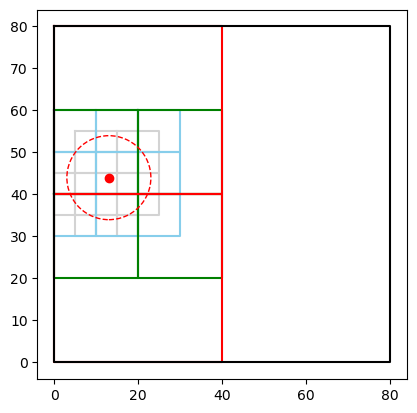

[(5.0, 10.0, 35.0, 30.0), (0, 5.0, 40.0, 35.0), (5.0, 10.0, 40.0, 35.0), (10.0, 15.0, 35.0, 30.0), (15.0, 20.0, 35.0, 30.0), (10.0, 15.0, 40.0, 35.0), (15.0, 20.0, 40.0, 35.0), (20.0, 25.0, 40.0, 35.0), (0, 5.0, 45.0, 40.0), (5.0, 10.0, 45.0, 40.0), (0, 5.0, 50.0, 45.0), (5.0, 10.0, 50.0, 45.0), (10.0, 15.0, 45.0, 40.0), (15.0, 20.0, 45.0, 40.0), (10.0, 15.0, 50.0, 45.0), (15.0, 20.0, 50.0, 45.0), (5.0, 10.0, 55.0, 50.0), (10.0, 15.0, 55.0, 50.0), (15.0, 20.0, 55.0, 50.0), (20.0, 25.0, 45.0, 40.0), (20.0, 25.0, 50.0, 45.0), (20.0, 25.0, 55.0, 50.0)]


In [279]:
index_ranges= []

camera_pos = (13,44)
r=10

fig, ax = plt.subplots()

draw_and_get_quadtree(camera_pos, qt, index_ranges, threshold=r)

camera_x, camera_y = camera_pos
ax.scatter(camera_x,camera_y, marker='o', color='red', zorder=5)

circle = plt.Circle(camera_pos, r, color='red', fill=False, linestyle='--', zorder=5)
ax.add_patch(circle)

ax.set_aspect('equal')

plt.show()
print(index_ranges)

The function returns the bounds of each of the lowest levels of the `quadtree`. Let's see what one of these cells looks like.

In [280]:
x_l, x_r, y_t, y_b=index_ranges[2]

x_l = int(x_l)
x_r = int(x_r)
y_t = int(y_t)
y_b = int(y_b)

grid[y_b:(y_t-1), x_l: (x_r-1)]

array([[ 0.,  0.,  0., 29.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

And now let's find out what objects lie within all our `quadtree` query results.

In [281]:

objects_found = np.array([])

for bounds in index_ranges:
    x_l, x_r, y_t, y_b = bounds

    x_l = int(x_l)
    x_r = int(x_r)
    y_t = int(y_t)
    y_b = int(y_b)

    qt_grid = grid[y_b:(y_t), x_l: (x_r)]
    object_indices = qt_grid[qt_grid != 0]
    objects_found = np.hstack((objects_found, object_indices))

num_objects_qt = np.count_nonzero(objects_found)
print(num_objects_qt)
print(objects_found)

19
[ 68.  18. 189.  29. 172. 192. 185.  71.  11. 140. 184.   9. 137.  57.
 161. 158.  59.  55. 151.]


This shows the power of spatial indexing. We have ~200 objects in the scene, yet our function is only looping through a fraction of them to determine which objects fall into our search radius.

In [282]:
print(f"Total Objects: {int(np.count_nonzero(grid))}")
print(f"QuadTree Returned Objects: {num_objects_qt}")
print(f"Ratio: {round(num_objects_qt/int(np.count_nonzero(grid)),2)}")

Total Objects: 199
QuadTree Returned Objects: 19
Ratio: 0.1


Now let's see which of these objects falls within our search radius.

In [283]:
objects_dict["145"]

(30, 25)

In [284]:
objects_in_radius = []

for i in objects_found:
    i = int(i)
    i = str(i)


    obj_X, obj_Y = objects_dict[i]

    distance = (obj_Y - camera_y)**2 + (obj_X - camera_x)**2

    if distance < r**2:
        objects_in_radius.append(i)

print(objects_in_radius)

['172', '11', '140', '184', '9', '137', '57', '161', '158', '55']


In [285]:
print(f"Total Objects: {int(np.count_nonzero(grid))}")
print(f"QuadTree Returned Objects: {num_objects_qt}")
print(f"Number of Objects in Radius: {len(objects_in_radius)}")

Total Objects: 199
QuadTree Returned Objects: 19
Number of Objects in Radius: 10


We get the final results. Just to see what this computational time explicitly looks like, let's compute the same for loop, but for every object in our array. This is how many mainstream Machine Learning algorithms work- ex: K-NN.

In [287]:
all_objects_in_array = grid[grid != 0]
new_objects_in_radius = []

for i in all_objects_in_array:
    i = int(i)
    i = str(i)

    obj_X, obj_Y = objects_dict[i]

    distance = (obj_Y - camera_y)**2 + (obj_X - camera_x)**2

    if distance < r**2:
        new_objects_in_radius.append(i)

print(new_objects_in_radius)

['172', '11', '184', '140', '9', '137', '55', '161', '158', '57']


We get the same results, as expected. However, in this example we had to loop over all the objects in the scene.

In [288]:
print(f"Total Objects: {int(np.count_nonzero(grid))}")
print(f"Function Queried Objects: {int(np.count_nonzero(grid))}")
print(f"Number of Objects in Radius: {len(new_objects_in_radius)}")

Total Objects: 199
Function Queried Objects: 199
Number of Objects in Radius: 10


## Scaling Up to 3D

Let's scale this up to 3D. We recreate our same grid from before with the third dimension.

In [289]:
grid_3d = np.zeros([80,80,80])
grid_3d.shape

(80, 80, 80)

We add 2000 objects to our scene this time.

In [290]:
# Create 200 random objects and add them to the grid.
objects_dict_3d = {}

for i in range (2000):
    X = np.random.randint(0,79)
    Y = np.random.randint(0,79)
    Z = np.random.randint(0,79)
    
    objects_dict_3d[str(i)]=(X,Y,Z)

    grid_3d[Z][Y][X] = i

np.count_nonzero(grid_3d)

np.int64(1992)

We define the `make_octree()` function below. In this case, each node will have 8 children.

In [304]:
def make_octree(x_l, x_r, y_t, y_b, z_f, z_b, depth=3):
    """
    Docstring for make_octree
    
    :param x_l: Description
    :param x_r: Description
    :param y_t: Description
    :param y_b: Description
    :param z_f: Description
    :param z_b: Description
    """
    octree = {}
    
    if depth == 0:
        return octree
    
    octree['bounds'] = (x_l, x_r, y_t, y_b, z_f, z_b)
    octree[0] = make_octree(x_l, x_r - (x_r - x_l)/2, y_t - (y_t - y_b)/2, y_b, z_f, z_b - (z_b - z_f)/2, depth-1)
    octree[1] = make_octree(x_r - (x_r - x_l)/2, x_r, y_t - (y_t - y_b)/2, y_b, z_f, z_b - (z_b - z_f)/2, depth-1)
    octree[2] = make_octree(x_l, x_r - (x_r - x_l)/2, y_t, y_t - (y_t - y_b)/2, z_f, z_b - (z_b - z_f)/2, depth-1)
    octree[3] = make_octree(x_r - (x_r - x_l)/2, x_r, y_t, y_t - (y_t - y_b)/2, z_f, z_b - (z_b - z_f)/2, depth-1)
    octree[4] = make_octree(x_l, x_r - (x_r - x_l)/2, y_t - (y_t - y_b)/2, y_b, z_b - (z_b - z_f)/2, z_b, depth-1)
    octree[5] = make_octree(x_r - (x_r - x_l)/2, x_r, y_t - (y_t - y_b)/2, y_b, z_b - (z_b - z_f)/2, z_b, depth-1)
    octree[6] = make_octree(x_l, x_r - (x_r - x_l)/2, y_t, y_t - (y_t - y_b)/2, z_b - (z_b - z_f)/2, z_b, depth-1)
    octree[7] = make_octree(x_r - (x_r - x_l)/2, x_r, y_t, y_t - (y_t - y_b)/2, z_b - (z_b - z_f)/2, z_b, depth-1)

    return octree

And our plotting function draw_cube() is defined as follows.

In [294]:
def draw_cube(coords, ax, color, **kwargs):
    """
    Docstring for draw_cube
    
    :param coords: Description
    :param plt: Description
    """
    x_l, x_r, y_t, y_b, z_f, z_b = coords
    X = np.array([x_l, x_l, x_r, x_r, x_l, x_l, x_l, x_r, x_r, x_l, x_l, x_l, x_l, x_l, x_l, x_r, x_r, x_r, x_r, x_r])
    Y = np.array([y_t, y_b, y_b, y_t, y_t, y_t, y_b, y_b, y_t, y_t, y_b, y_b, y_t, y_t, y_b, y_b, y_b, y_t, y_t, y_b])
    Z = np.array([z_f, z_f, z_f, z_f, z_f, z_b, z_b, z_b, z_b, z_b, z_b, z_f, z_f, z_b, z_b, z_b, z_f, z_f, z_b, z_b])
    
    ax.plot(X,Y,Z, color=color, **kwargs)

In [311]:
ot = make_octree(0,80,80,0,0,80, depth=5)
ot[4][7]["bounds"]

(20.0, 40.0, 40.0, 20.0, 60.0, 80)

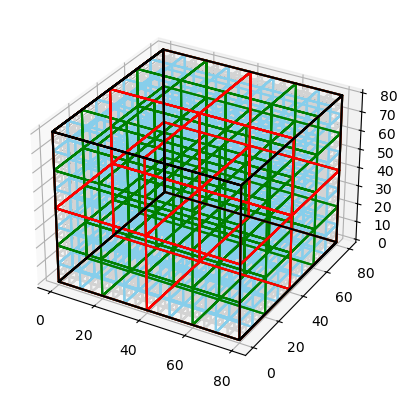

In [312]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

for i in range(8):
    for j in range(8):
        for k in range(8):
            for l in range(8):
                draw_cube(ot[i][j][k][l]['bounds'], ax3, 'lightgrey')

for i in range(8):
    for j in range(8):
        for k in range(8):
            draw_cube(ot[i][j][k]['bounds'], ax3, 'skyblue')

for i in range(8):
    for j in range(8):
        draw_cube(ot[i][j]['bounds'], ax3, 'green')

for i in range(8):
    draw_cube(ot[i]['bounds'], ax3, 'red')

draw_cube(ot['bounds'], ax3, 'black')

plt.show()

While computationally inefficient, the code appears to function as expected.

Let's recreate the is_intersecting code in 3D.

In [313]:
def is_intersecting_3d(pos: tuple, coords: tuple, threshold=5):
    """
    Docstring for is_intersecting
    
    :param pos: Description
    :type pos: tuple
    :param input_tree: Description
    :param threshold: Description
    """
    camera_x, camera_y, camera_z = pos
    x_l, x_r, y_t, y_b, z_f, z_b = coords

    # Find where the camera is with reference to the box

    # Base case for if camera is within the box
    if (x_l < camera_x) & (camera_x < x_r) & (y_b < camera_y) & (camera_y < y_t) & (z_b < camera_z) & (camera_z < z_b):
        return True

    # find the X, Y and Z coordinate of the nearest side of the box
    closest_x = max(x_l, min(camera_x, x_r))
    closest_y = max(y_b, min(camera_y, y_t))
    closest_z = max(z_f, min(camera_z, z_b))

    # find the length of the line from camera center to box edge
    curr_dist = (closest_x - camera_x)**2 + (closest_y - camera_y)**2 + (closest_z - camera_z)**2
    
    if curr_dist < threshold**2:
        return True
    else:
        return False

Let's recreate our `draw_quadtree()` function in 3D. Renaming it `draw_octree()`.

In [319]:
def draw_octree(pos:tuple, o_tree, threshold=5, level=0):
    """
    Docstring for draw_quadtree
    
    :param pos: Description
    :type pos: tuple
    :param o_tree: Description
    :param threshold: Description
    """
     
    if is_intersecting_3d(pos, o_tree['bounds'], threshold):
        draw_cube(o_tree['bounds'], plt, color_map[level], zorder=5-level)
        try:
            draw_octree(pos, o_tree[0], threshold, level = level+1)
        except:
            return
        
        try:
            draw_octree(pos, o_tree[1], threshold, level = level+1)
        except:
            return

        try:
            draw_octree(pos, o_tree[2], threshold, level = level+1)
        except:
            return
        
        try:
            draw_octree(pos, o_tree[3], threshold, level = level+1)
        except:
            return
        
        try:
            draw_octree(pos, o_tree[4], threshold, level = level+1)
        except:
            return
        
        try:
            draw_octree(pos, o_tree[5], threshold, level = level+1)
        except:
            return

        try:
            draw_octree(pos, o_tree[6], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, o_tree[7], threshold, level = level+1)
        except:
            return

    return

And let's see what our test results get.

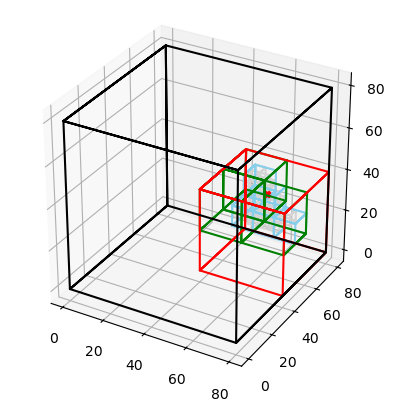

In [330]:
camera_pos_3d = (61,60,34)
r=10

fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

draw_octree(camera_pos_3d, ot, threshold=r)

camera_x, camera_y, camera_z = camera_pos_3d
ax3.scatter(camera_x, camera_y, camera_z, marker='X', color='red', zorder=5)

# circle = plt.Circle(camera_pos_3d, r, color='red', fill=False, linestyle='--', zorder=5)
# ax3.add_patch(circle)

ax3.set_aspect('equal')

plt.show()